In [26]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import json 

In [27]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    print("WARNING - no GPU found, training will be slow") 

In [28]:
class Automata(nn.Module):
    def __init__(self, program_in, program_out, memory_in, memory_out, k=1):
        super().__init__()

        self.program_in = program_in
        self.program_out = program_out 
        self.memory_in = memory_in
        self.memory_out = memory_out 

        self.modify_program = nn.Sequential(
            nn.Conv2d(program_in, program_out, (3,3), padding=(1,1)),
            nn.LeakyReLU(),
        )

        self.mask = nn.Sequential(
            nn.BatchNorm2d(program_out),
            nn.Conv2d(program_out, program_out, (1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(program_out, 6*memory_in, (1,1))
        )

        self.update = nn.Sequential(
            nn.BatchNorm2d(memory_in),
            nn.Conv2d(memory_in,memory_out, (1,1)),
            nn.LeakyReLU(),
            nn.Conv2d(memory_out,memory_out, (1,1)),
            nn.BatchNorm2d(memory_out),
        )
        self.activation = torch.nn.LeakyReLU()
        self.quantize_program = torch.nn.Softmax(dim=1) # torch.nn.Identity() #torch.nn.Tanh() 
        self.quantize_memory = torch.nn.Softmax(dim=1) #torch.nn.Identity() #torch.nn.Tanh() 

        self.k = k

    def forward(self, program, memory):
        b,c,h,w = memory.shape
        res_program = self.program_in == self.program_out 
        res_memory = self.memory_in == self.memory_out

        memory_in, memory_out = self.memory_in, self.memory_out
        program = program + self.modify_program(program) if res_program else self.modify_program(program) 

        mask = self.mask(self.quantize_program(program)).reshape((b,6,memory_in,h,w))
        xn = mask[:,0] 
        xm = mask[:,1] 
        yn = mask[:,2] 
        ym = mask[:,3] 
        c = mask[:,4]
        bias = mask[:,5]

        for i in range(self.k):
            res = memory 

            accum_y = yn* torch.cat([memory[:,:,0:1,:], memory[:,:,:-1,:]], dim=2) + ym * torch.cat([memory[:,:,1:,:], memory[:,:,-1:,:]],dim=2)
            accum_x = xn* torch.cat([memory[:,:,:,0:1], memory[:,:,:,:-1]], dim=3) + xm * torch.cat([memory[:,:,:,1:], memory[:,:,:,-1:]],dim=3)
            accum_c = c*memory
            accum = accum_x + accum_y + accum_c + bias

            memory = res + self.update(accum) if res_memory else self.update(accum)
            memory = self.activation(memory)
            memory = self.quantize_memory(memory)

        return program, memory

Automata(1,2,1,2)(torch.rand(1,1,10,10), torch.rand(1,1,10,10))

(tensor([[[[ 4.3346e-01,  4.6463e-01,  3.6429e-01,  2.6382e-01,  4.7702e-01,
             6.4016e-01,  5.0394e-01,  4.9928e-01,  4.6192e-01,  2.2694e-01],
           [ 5.5338e-01,  7.1003e-01,  7.9818e-01,  8.5441e-01,  6.0111e-01,
             6.1864e-01,  6.0352e-01,  6.0703e-01,  7.7348e-01,  5.6932e-01],
           [ 6.9905e-01,  6.9374e-01,  5.4161e-01,  5.4590e-01,  6.3059e-01,
             9.4078e-01,  7.7060e-01,  6.6637e-01,  7.8519e-01,  3.7221e-01],
           [ 5.5533e-01,  5.1000e-01,  7.2129e-01,  9.3025e-01,  5.0110e-01,
             5.4661e-01,  6.1226e-01,  4.7628e-01,  6.1123e-01,  6.0152e-01],
           [ 5.6237e-01,  7.3452e-01,  6.2523e-01,  8.0748e-01,  6.2460e-01,
             5.9517e-01,  5.5438e-01,  8.1575e-01,  7.1697e-01,  3.6088e-01],
           [ 4.2941e-01,  7.2116e-01,  6.5265e-01,  7.8973e-01,  6.7858e-01,
             5.5859e-01,  5.0962e-01,  4.6025e-01,  7.3729e-01,  5.9694e-01],
           [ 5.2754e-01,  6.3676e-01,  8.0266e-01,  6.9027e-01,  8.102

In [29]:
class FillInDataset:
    def __init__(self, n, k, height, width, max_thickness, transform=None):
        self.n = n 
        self.height = height 
        self.width = width
        self.k = k
        self.transform = transform

        self.images_border = []
        self.images_fill = []

        for j in range(self.n):
            height,width = self.height,self.width
            image_border = np.zeros((height,width,1), dtype=np.float32)
            image_fill = np.zeros((height,width,1), dtype=np.float32)

            min_width = height // 8
            min_height = width // 8
            border = width // 8       

            start_points = []
            end_points = [] 

            for i in range(self.k):
                thickness = np.random.randint(1, max_thickness+1)
                start_point = np.array([np.random.randint(border,width-border), np.random.randint(border,height-border)])
                end_point = np.array([np.random.randint(border,width-border), np.random.randint(border,height-border)])

                start_point, end_point = np.minimum(start_point,end_point), np.maximum(start_point,end_point)

                color = np.ones(1)
                #colors[i]
            
                cv2.rectangle(image_border, start_point, end_point, color, thickness) 
                
                cv2.rectangle(image_fill, start_point, end_point, color, -1) 

                start_points.append(start_point)
                end_points.append(end_point)

            for i in range(self.k):
                start_point, end_point = start_points[i], end_points[i]
                cv2.rectangle(image_fill, start_point, end_point, np.zeros(3), thickness) 

            self.images_border.append(image_border.astype(np.float32))
            self.images_fill.append(image_fill.astype(np.float32))

    def __len__(self):
        return self.n
    
    def __getitem__(self, it):
        x,y = self.images_border[it], self.images_fill[it]
        if self.transform:
            return self.transform(x), self.transform(y)
        return x,y

k = 3
colors = np.random.uniform(0.5,1.0,size=(k,3))
dataset = FillInDataset(10, 3, 32, 32, 1)

In [30]:
class DatasetBuildingETHAugmented:
    def __init__(self, image_path, image_annotated_path, image_size, n, transform=None, min_rect=4, thickness=2):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
        height,width = image.shape

        target_height, target_width = image_size

        with open(image_annotated_path) as f:
            image_annotated = json.load(f)  

        room_contours = []
        for room in image_annotated["floors"][0]["locations"]:
            contour = room["contour"]
            x0,x1,x2,x3 = contour

            room_contours.append(np.array([x0,x1,x3,x2], dtype=int))

        def polygon_intersect(polygon, x0, x1):
            return ((x0[None] <= polygon) & (polygon <= x1[None])).all(keepdims=1).any()

        min_width = height // 8
        min_height = width // 8
        max_width = height // 2
        max_height = height // 2
        border = width // 16      

        xs = []
        ys = []

        for i in range(n):
            sub_contours = []
            while  len(sub_contours) < min_rect:
                start_point = np.array([np.random.randint(border,width-border), np.random.randint(border,height-border)], dtype=int)
                end_point = start_point + np.array([np.random.randint(min_width,max_width), np.random.randint(min_height,max_height)], dtype=int)
                end_point = np.minimum([width,height], end_point)
                sub_contours = [((contour - start_point) / (end_point - start_point)[None] * [target_width,target_height]).astype(int) for contour in room_contours if polygon_intersect(contour, start_point, end_point)]

            sub_image = image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            sub_image = cv2.resize(sub_image, (target_width, target_height))

            label = np.zeros((target_height,target_width,1))
            
            cv2.drawContours(label, [contour[:,None] for contour in sub_contours], -1, np.ones(1), thickness=-1)
            cv2.drawContours(label, [contour[:,None] for contour in sub_contours], -1, np.zeros(1), thickness=thickness)
            
            xs.append(1 - sub_image.astype(np.float32))
            ys.append(label.astype(np.float32))

        self.xs = xs 
        self.ys = ys
        self.transform = transform

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, i):
        x,y = self.xs[i], self.ys[i]
        if self.transform:
            return self.transform(x), self.transform(y)
        return x,y


image_path = "../../../data/segmentation/gt/HG_Floor_G.png"
image_path_annotated = "../../../data/segmentation/gt/HG_Floor_G.json"

dataset = DatasetBuildingETHAugmented(image_path, image_path_annotated, n=10, image_size=(512,512), thickness=1)

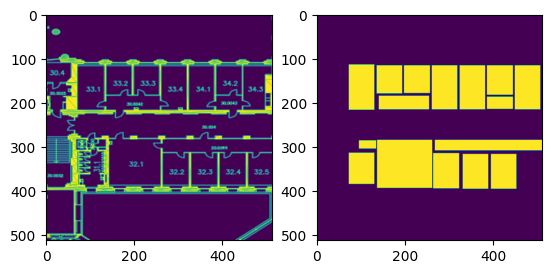

In [31]:
x,y = dataset[4]

fig,ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y)

In [32]:
class ConvBlockDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.max_pool = nn.MaxPool2d(2, stride=2, padding=0)

    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        x = self.max_pool(x)
        return x

class ConvBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=(2,2), stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        return x


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_image0 = ConvBlockDown(1,4)
        self.down_image1 = ConvBlockDown(4,8)
        self.down_image2 = ConvBlockDown(8,16)
        self.down_image3 = ConvBlockDown(16,32)

        self.up_image3 = ConvBlockUp(32,16)
        self.up_image2 = ConvBlockUp(32,24)
        self.up_image1 = ConvBlockUp(32,28)
        self.up_image0 = ConvBlockUp(32,16)

        self.final = nn.Sequential(
            nn.Conv2d(17,16,(3,3),padding=(1,1)),
            nn.ReLU()
        )

    def forward(self, x):
        x0 = self.down_image0(x)
        x1 = self.down_image1(x0)
        x2 = self.down_image2(x1)
        x3 = self.down_image3(x2)

        x4 = torch.cat([x2, self.up_image3(x3)], dim=1)
        x5 = torch.cat([x1, self.up_image2(x4)], dim=1)
        x6 = torch.cat([x0, self.up_image1(x5)], dim=1)
        x7 = torch.cat([x, self.up_image0(x6)], dim=1)
        x8 = self.final(x7)

        return x8

Encoder()(torch.zeros(1, 1, 16, 16))

tensor([[[[4.6754e-02, 4.9970e-02, 3.9761e-02,  ..., 5.0558e-02,
           4.1079e-02, 6.9947e-02],
          [3.7929e-02, 3.1497e-02, 2.6046e-02,  ..., 2.9731e-02,
           2.6062e-02, 5.8201e-02],
          [4.1128e-02, 3.9480e-02, 2.6084e-02,  ..., 3.8284e-02,
           2.6673e-02, 6.2660e-02],
          ...,
          [3.6389e-02, 3.2648e-02, 2.3397e-02,  ..., 3.2064e-02,
           2.5084e-02, 5.8839e-02],
          [4.1207e-02, 3.9438e-02, 2.7435e-02,  ..., 3.8294e-02,
           2.5795e-02, 6.1718e-02],
          [4.7248e-02, 4.5870e-02, 4.1928e-02,  ..., 4.6421e-02,
           4.4954e-02, 4.9194e-02]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 7.8882e-04],
          [0.0000e+00, 6.6826e-04, 0.0000e+00,  ..., 4.5931e-05,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 4.0416e-03, 3.1456e-03,  ..., 4.6096e-03,
           4.1787e-03, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [33]:

class AutomataBlockDown(nn.Module):
    def __init__(self, in_channels, out_channels, memory_in, memory_out):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.automata = Automata(in_channels, out_channels, memory_in, memory_out)
        self.max_pool = nn.MaxPool2d(2, stride=2, padding=0)

    def forward(self, x, m):
        x, m = self.automata(x, m)
        x, m = self.max_pool(x), self.max_pool(m)
        return x, m

class AutomataBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels, memory_in, memory_out):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.automata = Automata(in_channels, out_channels, memory_in, memory_out, k=2)
        self.up_conv_program = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        self.up_conv_memory = nn.ConvTranspose2d(memory_out, memory_out, kernel_size=2, stride=2)

    def forward(self, x, m):
        x, m = self.automata(x, m)
        return self.up_conv_program(x), self.up_conv_memory(m)

class DiffFlood(nn.Module):
    def __init__(self):
        super().__init__()

        self.down = nn.ModuleList([AutomataBlockDown(16,16, 1 if i==0 else 2,2) for i in range(4)])
        self.up = nn.ModuleList([AutomataBlockUp(16 if i==0 else 32,16,2,2) for i in range(4)])
        
        self.refine0 = Automata(32,16,2,2,k=1)
        self.refine1 = Automata(16,16,2,2,k=8)

    def forward(self, x):
        b,c,h,w = x.shape
        m = torch.ones((b,1,h,w), device=x.device)

        inputs = [x]
        for i in range(len(self.down)):
            x, m = self.down[i](x, m)
            inputs.append(x)    
        inputs = inputs[::-1]

        for i in range(len(self.up)):
            x, m = self.up[i](x, m)
            x = torch.cat([x, inputs[i+1]],dim=1)

        x,m = self.refine0(x,m)
        x,m = self.refine1(x,m)
        return x,m

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.diff_flood = DiffFlood()
        self.final = nn.Sequential(
            nn.Conv2d(2,2,(1,1)),
            nn.ReLU(),
            nn.Conv2d(2,1,(1,1)),
        )

    def forward(self, x):
        x = self.encoder(x)
        x,m = self.diff_flood(x)
        return self.final(m)

Model()(torch.rand(1,1,64,64))

tensor([[[[0.6485, 0.6485, 0.6485,  ..., 0.6485, 0.6485, 0.6485],
          [0.6485, 0.6485, 0.6485,  ..., 0.6485, 0.6485, 0.6485],
          [0.6485, 0.6485, 0.6485,  ..., 0.6485, 0.6485, 0.6485],
          ...,
          [0.6485, 0.6485, 0.6485,  ..., 0.6485, 0.6485, 0.6485],
          [0.6485, 0.6485, 0.6485,  ..., 0.6485, 0.6485, 0.6485],
          [0.6485, 0.6485, 0.6485,  ..., 0.6485, 0.6485, 0.6485]]]],
       grad_fn=<ConvolutionBackward0>)

In [34]:
image_path = "../../../data/segmentation/gt/HG_Floor_G.png"
image_path_annotated = "../../../data/segmentation/gt/HG_Floor_G.json"

training_data = DatasetBuildingETHAugmented(image_path, image_path_annotated, n=10000, image_size=(512,512), thickness=5, transform= transforms.ToTensor())
test_data = training_data # todo: use cab for test

train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

x,y = next(train_dataloader.__iter__())
x.shape, y.shape

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

tensor(0.) tensor(1.)


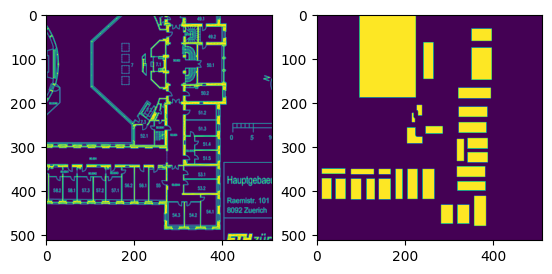

In [35]:
fig,ax = plt.subplots(1,2)
x,y = training_data[7]
print(x.min(), x.max())
ax[0].imshow(x.permute(1,2,0))
ax[1].imshow(y.permute(1,2,0))

In [36]:
num_epochs = 30
model = Model().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)



In [37]:
criterion = torch.nn.MSELoss()

In [38]:

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) 

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(outputs.min(), outputs.max())
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

tensor(0.3720, device='mps:0', grad_fn=<MinBackward1>) tensor(0.6391, device='mps:0', grad_fn=<MaxBackward1>)
Epoch [1/30], Step [10/2500], Loss: 0.2648
tensor(0.3315, device='mps:0', grad_fn=<MinBackward1>) tensor(0.6209, device='mps:0', grad_fn=<MaxBackward1>)
Epoch [1/30], Step [20/2500], Loss: 0.2578
tensor(0.3192, device='mps:0', grad_fn=<MinBackward1>) tensor(0.6038, device='mps:0', grad_fn=<MaxBackward1>)
Epoch [1/30], Step [30/2500], Loss: 0.2434
tensor(0.2940, device='mps:0', grad_fn=<MinBackward1>) tensor(0.5881, device='mps:0', grad_fn=<MaxBackward1>)
Epoch [1/30], Step [40/2500], Loss: 0.2387
tensor(0.2575, device='mps:0', grad_fn=<MinBackward1>) tensor(0.5734, device='mps:0', grad_fn=<MaxBackward1>)
Epoch [1/30], Step [50/2500], Loss: 0.2037
tensor(0.2356, device='mps:0', grad_fn=<MinBackward1>) tensor(0.5601, device='mps:0', grad_fn=<MaxBackward1>)
Epoch [1/30], Step [60/2500], Loss: 0.1889
tensor(0.1965, device='mps:0', grad_fn=<MinBackward1>) tensor(0.5484, device='mps:

KeyboardInterrupt: 

tensor(0.) tensor(1.)
tensor(-0.0041) tensor(0.9813)


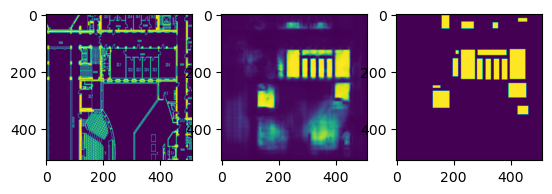

In [ ]:
x, y = training_data[71]

pred = model(x[None].to(device))[0]
pred = pred.detach().cpu().permute(1,2,0)
x = x.permute(1,2,0)
y = y.permute(1,2,0)
 
print(x.min(), x.max())
print(pred.min(), pred.max())

fig,ax = plt.subplots(1,3)
ax[0].imshow(x)
ax[1].imshow(pred)
ax[2].imshow(y)

In [ ]:
def calculate_angle(pt1, pt2, pt3):
    vec1 = pt1 - pt2
    vec2 = pt3 - pt2
    
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    
    cos_theta = dot_product / (magnitude1 * magnitude2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to handle numerical errors
    return np.degrees(angle)

def is_approx_rect(contour, thr = 10):
    n = len(contour)
    angles = np.zeros(n)
    for i in range(n):
        pt1 = contour[i - 1][0]
        pt2 = contour[i][0]
        pt3 = contour[(i + 1) % n][0]
        
        angle = calculate_angle(pt1, pt2, pt3)
        angles[i] = angle 
        
    return np.mean((angles - 90)**2) < thr*thr

def approx_contours(gray, min_width = 50):
    gray = cv2.GaussianBlur(gray, (3,3), 1.0)
    ret,gray = cv2.threshold(gray, 0.6, 1.0, cv2.THRESH_BINARY)
    #edges = cv2.Canny((gray*255).astype(np.uint8), 100, 200)

    contours, hierarchy = cv2.findContours((255*gray).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    approx_contours = []
    epsilon_factor = 0.06  # You can adjust this factor

    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx_contour = cv2.approxPolyDP(contour, epsilon, True)
        
        x,y = approx_contour[:,0,0], approx_contour[:,0,1]

        x0 = np.min(x),np.min(y)
        x1 = np.max(x),np.min(y)
        x2 = np.max(x),np.max(y)
        x3 = np.min(x),np.max(y)

        approx_contour = np.array([x0,x1,x2,x3])[:,None]

        if not (is_approx_rect(approx_contour) and max(np.max(x)-np.min(x), np.max(y)-np.min(y)) > min_width):
            continue

        approx_contours.append(np.array([x0,x1,x2,x3])[:,None])

    return gray, approx_contours

approx_contours(np.zeros((32,32,1)))

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [])

(1403, 1985)
(1403, 1985) (1024, 1024)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_29304\3670856573.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (magnitude1 * magnitude2)


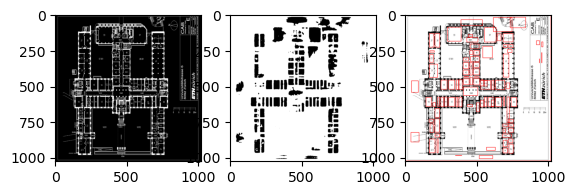

In [ ]:
img = cv2.imread("ground_truth_to_graph/CAB_Floor_E.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

print(img.shape)
#img = img[y0:y0+1024, x0:x0+1024]
height,width = img.shape 

size = 1024
img = np.where(img > 0.8, 1.0, 0.0).astype(np.float32)
img_small = 1-cv2.resize(img, (size,size))
print(img.shape, img_small.shape)

img_trans = transforms.ToTensor()(img_small)[None]
pred = model(img_trans.to(device))[0]
pred = pred.detach().cpu().permute(1,2,0)

thr, contours = approx_contours(1.0-pred.numpy(), min_width=size/40)

image_with_contours = cv2.cvtColor(1-img_small, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_with_contours, contours, -1, (1.0, 0, 0), 2)

image_ml = image_with_contours

fig,ax = plt.subplots(1,3)
ax[0].imshow(img_small, cmap='gray')
ax[1].imshow(thr, cmap='gray')
ax[2].imshow(image_with_contours, cmap='gray')
#ax[2].imshow(y)

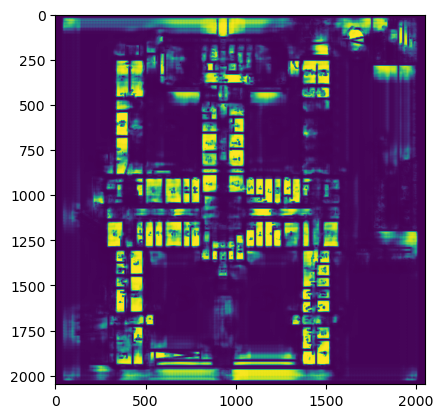

In [ ]:
plt.imshow(pred)

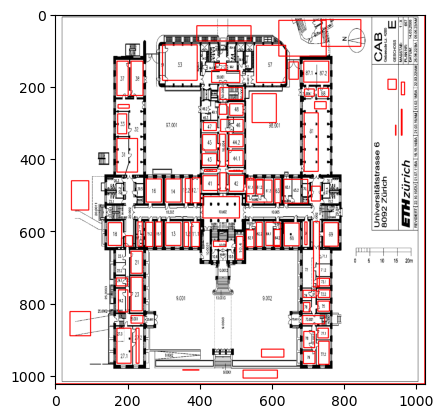

In [ ]:
image_ml = image_with_contours
plt.imshow(image_with_contours)

In [ ]:
#torch.save(model.state_dict(), "model.pt")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28008\3670856573.py:9: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (magnitude1 * magnitude2)


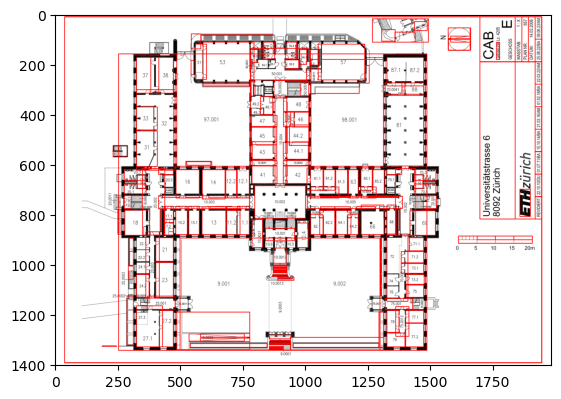

In [ ]:
img = 1 - cv2.imread("ground_truth_to_graph/CAB_Floor_E.png", cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255

def approx_contours(gray, min_width = 50):
    gray = cv2.GaussianBlur(gray, (5,5), 1.0)
    ret,gray = cv2.threshold(gray, 0.3, 1.0, cv2.THRESH_BINARY)
    edges = cv2.Canny((gray*255).astype(np.uint8), 100, 200)

    contours, hierarchy = cv2.findContours((255*gray).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    approx_contours = []
    epsilon_factor = 0.03  # You can adjust this factor

    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx_contour = cv2.approxPolyDP(contour, epsilon, True)
        
        x,y = approx_contour[:,0,0], approx_contour[:,0,1]

        x0 = np.min(x),np.min(y)
        x1 = np.max(x),np.min(y)
        x2 = np.max(x),np.max(y)
        x3 = np.min(x),np.max(y)

        approx_contour = np.array([x0,x1,x2,x3])[:,None]

        if not (is_approx_rect(approx_contour) and max(np.max(x)-np.min(x), np.max(y)-np.min(y)) > min_width):
            continue

        approx_contours.append(np.array([x0,x1,x2,x3])[:,None])

    return gray, approx_contours

_,contours = approx_contours(img)
image_with_contours = 1-cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_with_contours, contours, -1, (1.0, 0, 0), 2)

plt.imshow(image_with_contours)

1.0


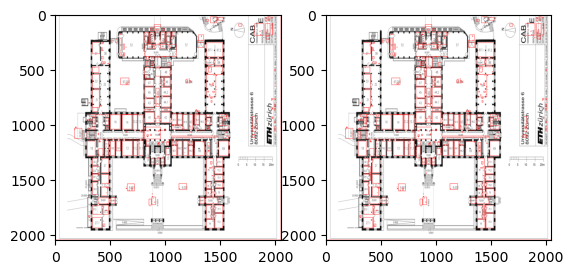

In [ ]:
fig, ax = plt.subplots(1,2)
print(image_with_contours.max())
ax[0].imshow(image_with_contours)
ax[1].imshow(image_ml)

In [ ]:
cv2.imwrite("classic.png", 255*image_with_contours)
cv2.imwrite("model.png", 255*cv2.resize(image_ml, (img.shape[1],img.shape[0])))

True